In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import time
import pandas as pd
import pickle as pkl
import librosa as lb
from sklearn import metrics

In [2]:
user = 'tshaw'

# Alignment

In [3]:
def evalAlignments(pairsFile, annotFile, hypRoot, editDur, saveFile = None, \
                           hop_sec = 0.01, scoring_collar = 0.1, maxTol = 1000):
    annotList = list(map(lambda x: x.split(), open(annotFile, 'r').readlines()))
    alignmentErrors = []
    with open(pairsFile, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            
            # Find correct annotations
            queryId = os.path.basename(parts[0])[:-4] # [:-4] here to get rid of .wav
            annot = findAnnot(annotList, queryId)
            
            # Find path
            hypFile = hypRoot + '/' + queryId[:-4] + '.pkl' # [:-4] here to get rid of _160
            hyp = pkl.load(open(hypFile, 'rb'))
            
            queryErrors = getAlignmentError(hyp, annot, hop_sec, scoring_collar, editDur)
            
            alignmentErrors.append(queryErrors)
    # Stack alignmentErrors
    alignmentErrors = np.hstack(alignmentErrors)
    # Get error rates at error tols
    errorRates = calcErrorRates(alignmentErrors, maxTol)
    # Save and return
    if saveFile is not None:
        outdir = os.path.dirname(saveFile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
        pkl.dump(errorRates, open(saveFile, 'wb'))
    
    return errorRates

In [4]:
def findAnnot(annotList, queryId):
    for annot in annotList:
        if annot[1] == queryId:
            return annot
    
    print("Error: Annotations not found")
    return None

In [5]:
def getAlignmentError(hyp, annot, hop_sec, scoring_collar, editDur):
    tamperType = annot[0]
    path = hyp['wp']
    queryLength = path[0,0]
    
    # Get GT
    gtPath = getAlignmentGT(tamperType, annot, scoring_collar, queryLength, hop_sec, editDur)

    # Interp valid frames over path to get preds
    # Multiply ref frames by hopsec to get timestamps
    preds = np.interp(gtPath[:,0], path[:,0][::-1], path[:,1][::-1] * hop_sec)    
    
    # Compare preds to GT timestamps
    errors = preds - (gtPath[:,1] * hop_sec)
    
    return errors

In [6]:
def getAlignmentGT(tamperType, annot, scoring_collar, queryLength, hop_sec, editDur):
    '''
    Gets the GT alignment path. 
    Note that this path skips over invalid sections (tampered or within scoring collar)
    '''
    gtPath = np.zeros((queryLength, 2))
    gtPath[:,0] = np.arange(queryLength)
    
    if tamperType == "N":  # Not tampered: diagonal path and everything valid
        pathStart = float(annot[3])
        pathStartFrame = int(np.round(pathStart / hop_sec))
        pathEndFrame = pathStartFrame + queryLength
        gtPath[:,1] = np.arange(pathStartFrame, pathEndFrame)
        return gtPath
    
    elif tamperType == "I":  # Insertion
        pathStart = float(annot[3])
        pathStartFrame = int(np.round(pathStart / hop_sec))
        #pathEnd = float(annot[4])
        #pathEndFrame = int(np.round(pathEnd / hop_sec))
        
        insertionStart = float(annot[5])
        invalidStart = max(0,insertionStart - scoring_collar)
        invalidEnd = insertionStart + editDur + scoring_collar  # Skip inserted editDur
        invalidStartFrame = int(np.ceil(invalidStart / hop_sec))
        invalidEndFrame = int(np.ceil(invalidEnd / hop_sec))
        
        refInvalidEnd = pathStart + insertionStart + scoring_collar
        refInvalidEndFrame = int(np.ceil(refInvalidEnd / hop_sec))
        
        gtPath[:invalidStartFrame,1] = np.arange(pathStartFrame, pathStartFrame + invalidStartFrame)
        framesLeft = gtPath[invalidEndFrame:,1].shape[0]
        gtPath[invalidEndFrame:,1] = np.arange(refInvalidEndFrame, refInvalidEndFrame + framesLeft)
        
        gtPath = np.delete(gtPath, slice(invalidStartFrame,invalidEndFrame), axis = 0)
        return gtPath
    
    elif tamperType == "D":
        pathStart = float(annot[3])
        pathStartFrame = int(np.round(pathStart / hop_sec))
        #pathEnd = float(annot[4])
        #pathEndFrame = int(np.round(pathEnd / hopsec))
        
        deletionStart = float(annot[5])
        invalidStart = max(0,deletionStart - scoring_collar)
        invalidEnd = deletionStart + scoring_collar
        invalidStartFrame = int(np.ceil(invalidStart / hop_sec))
        invalidEndFrame = int(np.ceil(invalidEnd / hop_sec))
        
        refInvalidEnd = pathStart + deletionStart + editDur + scoring_collar  # Skip deleted editDur
        refInvalidEndFrame = int(np.ceil(refInvalidEnd / hop_sec))
        
        gtPath[:invalidStartFrame,1] = np.arange(pathStartFrame, pathStartFrame + invalidStartFrame)
        framesLeft = gtPath[invalidEndFrame:,1].shape[0]
        gtPath[invalidEndFrame:,1] = np.arange(refInvalidEndFrame, refInvalidEndFrame + framesLeft)
        
        gtPath = np.delete(gtPath, slice(invalidStartFrame,invalidEndFrame), axis = 0)
        return gtPath
    
    elif tamperType == "R":
        pathStart = float(annot[3])
        pathStartFrame = int(np.round(pathStart / hop_sec))
        #pathEnd = float(annot[4])
        #pathEndFrame = int(np.round(pathEnd / hopsec))
        
        replacementStart = float(annot[5])
        invalidStart = max(0, replacementStart - scoring_collar)
        invalidEnd = replacementStart + editDur + scoring_collar  # Skip replaced editDur
        invalidStartFrame = int(np.ceil(invalidStart / hop_sec))
        invalidEndFrame = int(np.ceil(invalidEnd / hop_sec))
        
        refInvalidEnd = pathStart + replacementStart + editDur + scoring_collar  # Skip replaced editDur
        refInvalidEndFrame = int(np.ceil(refInvalidEnd / hop_sec))

        gtPath[:invalidStartFrame,1] = np.arange(pathStartFrame, pathStartFrame + invalidStartFrame)
        framesLeft = gtPath[invalidEndFrame:,1].shape[0]
        gtPath[invalidEndFrame:,1] = np.arange(refInvalidEndFrame, refInvalidEndFrame + framesLeft)
        gtPath = np.delete(gtPath, slice(invalidStartFrame,invalidEndFrame), axis = 0)
        return gtPath
    else:
        print("Invalid Tamper Type: ", tamperType)
        return np.array([])

In [7]:
def calcErrorRates(errors, maxTol):
    errorTols = np.arange(maxTol + 1).reshape(-1,1) / 1000
    
    correct = (np.abs(errors.reshape(1,-1)) <= errorTols).astype(int)
    
    errorRates = 1 - (np.sum(correct, axis = 1) / errors.shape[0])
    
    return errorRates

## Run Alignment Eval

In [8]:
editTimes = [1, 2, 3, 4]
benchmark = 'train'
systems = ["D1", "D2", "D3", "D4", "NW-60", "HSTW"]
for editTime in editTimes:
    for sys in systems:
        pairsFile = "/mnt/data0/%s/TamperingDetection/cfg_files/%s_%ss.pairs" % (user, benchmark, str(editTime))
        annotFile = "/mnt/data0/%s/TamperingDetection/annots/160kbps_%ssec.gt" % (user, str(editTime))
        pathsRoot = "/mnt/data0/%s/TamperingDetection/hyp/%ssec/%s" % (user, str(editTime), sys)
        saveFile = "/mnt/data0/%s/TamperingDetection/eval/alignment/%s/%s_%ss.pkl" % \
                    (user, sys, benchmark, str(editTime))
        
        errRates = evalAlignments(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

## Alignment Figure

In [9]:
def plotAlignment(timesToPlot, systemsToPlot, errorCurveDir, benchmark, legend, title="Alignment Error Rates"):
    fig, axs = plt.subplots(1, len(timesToPlot), figsize = (11, 7))
    x = np.arange(4)
    numBars = len(systemsToPlot)
    width = 0.75 / numBars
    
    for i, plotTime in enumerate(timesToPlot):
        axs[i].grid(zorder=0)
        for j, sys in enumerate(systemsToPlot):
            errorsFile = errorCurveDir + "/%s/%s_%ss.pkl" % (sys, benchmark, str(plotTime))
            errorCurve = pkl.load(open(errorsFile, 'rb'))
            axs[i].bar(x - width * (numBars / 2) + (j + 1/2) * width, errorCurve[[20, 50, 100, 200]] * 100, width, zorder = 3)
#         axs[i].set_xlabel("Error Tolerance (ms)")
        axs[i].set_xticks(x)
        axs[i].set_xticklabels([20, 50, 100, 200])
        axs[i].set_ylim(0,15)
        axs[i].set_title("L = " + str(plotTime))

    plt.legend(legend, loc = (1.1, 0.5))
    fig.suptitle(title, fontsize = 'x-large')
    axs[0].set_ylabel("Error Rate (%)", fontsize = "large")
    fig.text(0.5, -0.01, 'Error Tolerance (ms)', ha='center', fontsize = "large")
    fig.tight_layout()

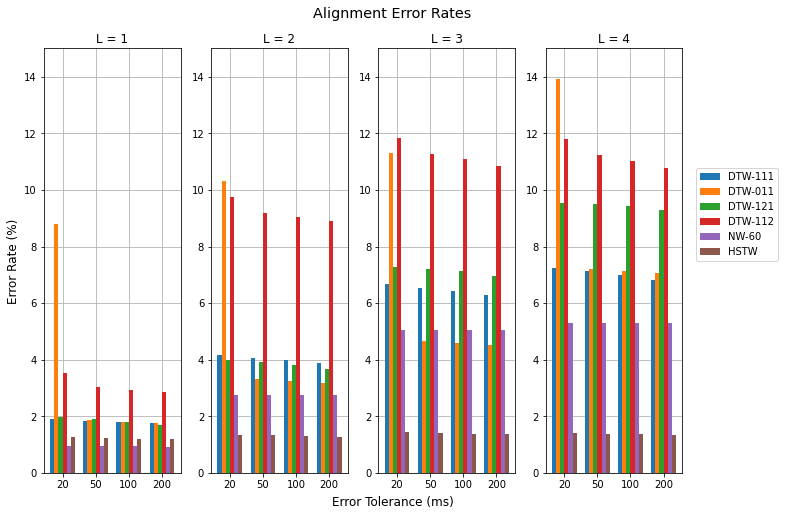

In [10]:
benchmark = "train"
timesToPlot = [1, 2, 3, 4]

systemsToPlot = ["D1", "D2", "D3", "D4", "NW-60", "HSTW"]
systemNames = ["DTW-111", "DTW-011","DTW-121", "DTW-112", "NW-60","HSTW"]

errorCurveDir = "/mnt/data0/%s/TamperingDetection/eval/alignment" % user

plotAlignment(timesToPlot, systemsToPlot, errorCurveDir, benchmark, systemNames)

# Attribution

In [11]:
def evalAttribution(pairsFile, annotFile, pathsRoot, editDur, scoring_collar = 0.1, \
                   saveFile = None, hop_sec = 0.01, usePlane = False):
    attributions = []
    annotList = list(map(lambda x: x.split(), open(annotFile, 'r').readlines()))
    
    with open(pairsFile, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            
            # Find correct annotations
            queryId = os.path.basename(parts[0])[:-4] # [:-4] here to get rid of .wav
            annot = findAnnot(annotList, queryId)
            
            # Find path
            pathFile = pathsRoot + '/' + queryId[:-4] + '.pkl' # [:-4] here to get rid of _160
            if not os.path.exists(pathFile):
                print("Skip: ", pathFile)
                continue
            path = pkl.load(open(pathFile, 'rb'))

            theseAttributions = evalQueryAttrib(path, annot, scoring_collar, editDur, hop_sec, usePlane)
            
            attributions.append(theseAttributions)

    attributions = np.vstack(attributions)
    
    if usePlane:
        if saveFile is not None:
            outdir = os.path.dirname(saveFile)
            outdir = Path(outdir)
            outdir.mkdir(parents=True, exist_ok=True)
            pkl.dump(attributions, open(saveFile, 'wb'))
        
        return attributions
    else:
        ROC = calc_ROC(attributions)
        if saveFile is not None:
            outdir = os.path.dirname(saveFile)
            outdir = Path(outdir)
            outdir.mkdir(parents=True, exist_ok=True)
            pkl.dump(ROC, open(saveFile, 'wb'))

        return ROC

In [12]:
def calc_ROC(attributions):
    flippedGT = (attributions[:,0] == 0).astype(int)
    fps, tps, thresholds = metrics.roc_curve(flippedGT, attributions[:,1])
    # Now FP means called non-match when really a match, which is really a FN,
    # So save FP in third col of ROC
    return np.array([thresholds, 1-tps, fps]).T

In [78]:
def evalQueryAttrib(hyp, annot, scoring_collar, editDur, hop_sec, usePlane):
    tamperType = annot[0]
    attributions = []
    path = hyp['wp']
    queryLength = path[0,0]
    gt = np.ones(queryLength)

    if usePlane:  # For using hidden vs visible plane to make predictions with HSTW
        pathPreds = (path[:,2] == 0).astype(int)  # Flip so visible plane is match
    else:
        pathPreds = hyp['dist']
    
    # Set up gt depending on tamper type and store boundaries (in sec) to mark collar after
    # GT is 0 for matching frame, 1 for non-matching frame
    if tamperType == "N":
        boundaries = []
    
    elif tamperType == "I":
        insertionStart = float(annot[5])
        insertionEnd = insertionStart + editDur
        boundaries = [insertionStart, insertionEnd]
        
        insertionStartFrame = int(np.round(insertionStart / hop_sec))
        insertionEndFrame = int(np.round(insertionEnd / hop_sec))
        gt[insertionStartFrame:insertionEndFrame] = 0
        
    elif tamperType == "D": # For deletions, we have 1 boundary but no non-matching frames
        deletionStart = float(annot[5])
        boundaries = [deletionStart]        
    
    else: # replacement
        replacementStart = float(annot[5])
        replacementEnd = replacementStart + editDur
        boundaries = [replacementStart, replacementEnd]
        
        replacementStartFrame = int(np.round(replacementStart / hop_sec))
        replacementEndFrame = int(np.round(replacementEnd / hop_sec))
        gt[replacementStartFrame:replacementEndFrame] = 0
    
    # Set scoring collar to -1 around each boundary
    for boundary in boundaries:
        collarStartTime = boundary - scoring_collar
        collarStartFrame = int(np.ceil(collarStartTime / hop_sec))
        collarEndTime = boundary + scoring_collar
        collarEndFrame = int(np.ceil(collarEndTime / hop_sec))
        gt[collarStartFrame:collarEndFrame] = -1
    
    # Impute cost scores
    # Interpolate here to fill in the frames that the path jumps over
    preds = np.interp(np.arange(queryLength), path[:,0][::-1], pathPreds[::-1])
    
    if usePlane: # for vis vs hidden, the frames that are in both planes default to visible (match)
        preds = np.ceil(preds)

    attributions = np.hstack((gt.reshape((-1,1)), preds.reshape((-1,1))))
        
    # Filter out the gt=-1 frames that are within the scoring collar of a boundary
    collarFilter = gt >= 0
    attributions = attributions[collarFilter, :]
         
    return attributions

## Run Attribution Eval

In [79]:
editTimes = [1, 2, 3, 4]
benchmark = 'train'
systems = ["D1", "D2", "D3", "D4", "NW-60", "HSTW"]

for editTime in editTimes:
    for sys in systems:
        pairsFile = "/mnt/data0/%s/TamperingDetection/cfg_files/%s_%ss.pairs" % (user, benchmark, str(editTime))
        annotFile = "/mnt/data0/%s/TamperingDetection/annots/160kbps_%ssec.gt" % (user, str(editTime))
        pathsRoot = "/mnt/data0/%s/TamperingDetection/hyp/%ssec/%s" % (user, str(editTime), sys)
        saveFile = "/mnt/data0/%s/TamperingDetection/eval/attribution/%s/%s_%ss.pkl" % \
                    (user, sys, benchmark, str(editTime))
        
        ROC = evalAttribution(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

In [80]:
editTimes = [1, 2, 3, 4]
benchmark = 'train'

for editTime in editTimes:
    pairsFile = "/mnt/data0/%s/TamperingDetection/cfg_files/%s_%ss.pairs" % (user, benchmark, str(editTime))
    annotFile = "/mnt/data0/%s/TamperingDetection/annots/160kbps_%ssec.gt" % (user, str(editTime))
    pathsRoot = "/mnt/data0/%s/TamperingDetection/hyp/%ssec/HSTW" % (user, str(editTime))
    saveFile = "/mnt/data0/%s/TamperingDetection/eval/attribution/HSTW/planeAttrib/%s_%ss.pkl" \
                % (user, benchmark, str(editTime))
        
    ROC = evalAttribution(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile, usePlane = True)

## Attribution Plots

In [111]:
def plotAttribution(timesToPlot, systemsToPlot, benchmark, sysNames, ROCDir):
    x = np.arange(len(timesToPlot))
    numBars = len(systemsToPlot)
    width = 0.75 / numBars
    plt.grid(zorder=0)
    for i, plotSys in enumerate(systemsToPlot):
        EERs = []
        barLocs = x - width * (numBars / 2) + (i+0.5) * width
        for j, plotTime in enumerate(timesToPlot):
            
            ROCfile = ROCDir + "/%s/%s_%ss.pkl" % (plotSys, benchmark, str(plotTime))

            ROC = pkl.load(open(ROCfile, 'rb'))
            EERs.append(findEER(ROC))

        plt.bar(barLocs, np.array(EERs) * 100, width, zorder = 3)
        
        plt.xlabel("Edit Duration (s)")
        plt.xticks(x, timesToPlot)
        plt.ylim(0,20)
        plt.title("Attribution Error Rates")

    plt.legend(sysNames, loc = (1.05, 0.57))
    plt.ylabel("Equal Error Rate (%)", fontsize = "large")

In [112]:
def findEER(ROC):
    '''
    Calculates Equal Error Rate based on ROC
    
    '''
    diffs = np.abs(ROC[:,1] - ROC[:,2])
    
    best = np.argmin(diffs)
    
    return (ROC[best,1] + ROC[best,2]) / 2

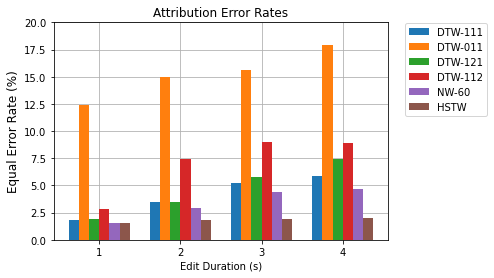

In [113]:
ROCDir = "/mnt/data0/%s/TamperingDetection/eval/attribution" % user

timesToPlot = [1,2,3,4]
systemsToPlot = ["D1", "D2", "D3", "D4", "NW-60", "HSTW"]
sysNames =  ["DTW-111", "DTW-011","DTW-121", "DTW-112", "NW-60","HSTW"]
benchmark = "train"

plotAttribution(timesToPlot, systemsToPlot, benchmark, sysNames, ROCDir)

In [100]:
def plotROCs(rocFiles, planeAttribFiles, sysNames):
    for rocFile in rocFiles:
        ROC = pkl.load(open(rocFile, 'rb'))
        plt.plot(ROC[:,1] * 100, ROC[:,2] * 100) # x = falsePositive, y = falseNegative
    
    plt.legend(sysNames, loc = (1.02, 0.57))
    plt.xlabel("False Positive Rate (%)")
    plt.ylabel("False Negative Rate (%)")
    plt.title("ROC Curves for 2 Second Edit Duration")
    plt.xlim(0,25)
    plt.ylim(0,25)
    
    # Plane attrib files
    # Use calc_FPFN function maybe?
    for paFile in planeAttribFiles:
        attribs = pkl.load(open(paFile, 'rb'))
        diffs = attribs[:,1] - attribs[:,0] # 0 for correct, 1 for fp, -1 for fn
        fp = np.sum(diffs == 1) / (np.sum(attribs[:,0] == 0)) # num fp / num true neg
        fn = np.sum(diffs == -1) / (np.sum(attribs[:,0] == 1)) # num fn / num true pos
        plt.plot(fp * 100, fn * 100, 'kx', markersize = 6)
        

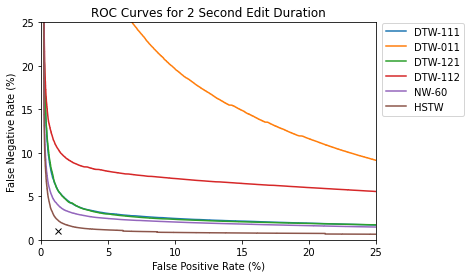

In [101]:
editTime = 2
benchmark = "train"
systemsToPlot = ["D1", "D2", "D3", "D4", "NW-60", "HSTW"]
sysNames =  ["DTW-111", "DTW-011","DTW-121", "DTW-112", "NW-60","HSTW"]

rocFiles = []
for sys in systemsToPlot:
    rocFile = "/mnt/data0/%s/TamperingDetection/eval/attribution/%s/%s_%ss.pkl" % \
                (user, sys, benchmark, str(editTime))
    rocFiles.append(rocFile)


planeAttribFiles = []
paSystems = ["HSTW"]
for sys in paSystems:
    paFile = "/mnt/data0/%s/TamperingDetection/eval/attribution/%s/planeAttrib/%s_%ss.pkl" \
                % (user, sys, benchmark, str(editTime))
    planeAttribFiles.append(paFile)

    
plotROCs(rocFiles, planeAttribFiles, sysNames)

In [104]:
paFile = "/mnt/data0/%s/TamperingDetection/eval/attribution/%s/planeAttrib/%s_%ss.pkl" \
                % (user, sys, benchmark, str(editTime))

In [105]:
attribs = pkl.load(open(paFile, 'rb'))

In [106]:
attribs

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [107]:
diffs = attribs[:,1] - attribs[:,0] # 0 for correct, 1 for fp, -1 for fn

In [108]:
fp = np.sum(diffs == 1) / (np.sum(attribs[:,0] == 0)) # num fp / num true neg
fn = np.sum(diffs == -1) / (np.sum(attribs[:,0] == 1)) # num fn / num true pos

In [109]:
fn

0.010247764705615947

In [110]:
fp

0.012961194162464737